## Домашка (10 баллов)


Обучите модель с минимум 15 слоями, где у каждого слоя разные параметры (Dropout, Conv1d и Pooling, Dense считаются слоями, остальное нет). Как мимнимум 4 слоя должны быть наложены друг на друга и как минимум 2 параллельных слоя (последовательности слоев). Должен быть хотя бы один слой каждого типа.

При обучении используйте колбек для отслеживания лучшей модели. Ориентируйтесь на ф1 меру. Качество модели не должно быть околонулевым. Если метрики не растут, то попробуйте пообучать подольше или перестроить саму сеть.

Советы: Начните с небольших сетей и постепенно добавляйте, не пытайтесь сразу собрать все слои. Иногда кернел может крашиться просто так или из-за слишком больших матриц.


### Сначала я тестирую модели с 3 и 6 слоями, в конце запускаю модель с 15 слоями

In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras

import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
print(keras.__version__)

2.15.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv('/content/drive/MyDrive/lenta_40k.csv.zip')

In [5]:
data

,text,topic
0,Россия должна сотрудничать с Всемирным антидоп...,Спорт
1,Уголовный суд Кувейта 28 июня освободил под за...,Мир
2,Французский журнал Charlie Hebdo опубликовал н...,Интернет и СМИ
3,В Петербурге в доме № 53 по улице Лени Голиков...,Россия
4,"В московском аэропорту ""Домодедово"" задержан г...",Россия
...,...,...
44351,Российский Минфин может пересмотреть минимальн...,Экономика
44352,Сотрудники Службы безопасности Украины (СБУ) с...,Бывший СССР
44353,Америке следует задуматься над поставками на У...,Силовые структуры
44354,"Опознаны тела 71 человека, погибшего в результ...",Мир


In [6]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    tokens = [token for token in tokens if token]
    return tokens

In [7]:
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [8]:
len(filtered_vocab)

24090

In [9]:
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

In [10]:
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [11]:
MAX_LEN = max(len(x) for x in X)
MEAN_LEN = np.median([len(x) for x in X])

In [12]:
MAX_LEN, MEAN_LEN

(1732, 169.0)

In [13]:
MAX_LEN = int(MEAN_LEN + 31)

In [14]:
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [15]:
X.shape

(44356, 200)

In [16]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

In [17]:
y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [19]:
checkpoint = keras.callbacks.ModelCheckpoint('model.weights.h5', monitor='f1_score', verbose=1, save_weights_only=True, save_best_only=True, mode='max',save_freq='epoch')
early_stop = keras.callbacks.EarlyStopping(monitor='f1_score', min_delta=0.04, patience=3, verbose=1, mode='max',)

### Модель №1 - 3 слоя

In [20]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs)

conv1 = keras.layers.Conv1D(kernel_size=10, filters=32, strides=1)(embeddings)

mean = keras.layers.Flatten()(conv1)

dense = keras.layers.Dense(30, activation='relu')(mean)


outputs = keras.layers.Dense(len(label2id), activation='softmax')(dense)


model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec'), keras.metrics.F1Score(average="weighted")])

In [21]:
model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=2000, epochs=10, callbacks=[checkpoint, early_stop])

Epoch 1/10
22/22 [==============================] - ETA: 0s - loss: 2.7093 - rec@prec: 0.0000e+00 - f1_score: 0.1002
Epoch 1: f1_score improved from -inf to 0.10015, saving model to model.weights.h5
22/22 [==============================] - 22s 930ms/step - loss: 2.7093 - rec@prec: 0.0000e+00 - f1_score: 0.1002 - val_loss: 2.4703 - val_rec@prec: 0.0000e+00 - val_f1_score: 0.0995
Epoch 2/10
22/22 [==============================] - ETA: 0s - loss: 2.3374 - rec@prec: 2.3732e-05 - f1_score: 0.1206
Epoch 2: f1_score improved from 0.10015 to 0.12058, saving model to model.weights.h5
22/22 [==============================] - 23s 1s/step - loss: 2.3374 - rec@prec: 2.3732e-05 - f1_score: 0.1206 - val_loss: 2.2660 - val_rec@prec: 0.0000e+00 - val_f1_score: 0.1175
Epoch 3/10
22/22 [==============================] - ETA: 0s - loss: 2.0916 - rec@prec: 0.0054 - f1_score: 0.2292
Epoch 3: f1_score improved from 0.12058 to 0.22921, saving model to model.weights.h5
22/22 [==============================] -

dict_keys(['loss', 'rec@prec', 'f1_score', 'val_loss', 'val_rec@prec', 'val_f1_score'])


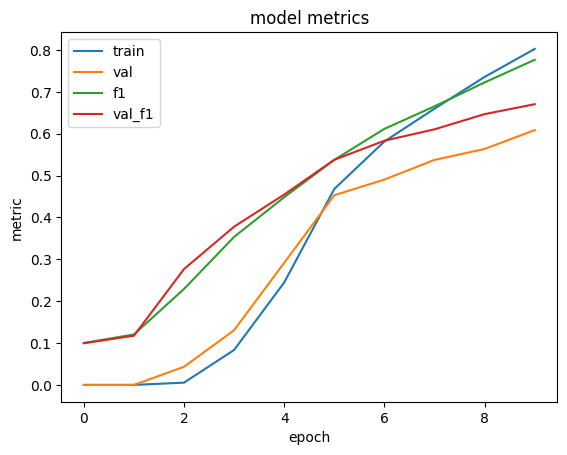

In [22]:
print(model.history.history.keys())
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.plot(model.history.history['f1_score'])
plt.plot(model.history.history['val_f1_score'])
plt.title('model metrics')
plt.ylabel('metric')
plt.xlabel('epoch')
plt.legend(['train', 'val',
            'f1', 'val_f1'], loc='upper left')
plt.show()

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 30)           722730    
                                                                 
 conv1d (Conv1D)             (None, 191, 32)           9632      
                                                                 
 flatten (Flatten)           (None, 6112)              0         
                                                                 
 dense (Dense)               (None, 30)                183390    
                                                                 
 dense_1 (Dense)             (None, 19)                589       
                                                                 
Total params: 916341 (3.50 MB)
Trainable params: 916341 (3.50

### Модель №2 - 6 слоёв

In [24]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs)

conv1 = keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(embeddings)
conv2 = keras.layers.Conv1D(kernel_size=5, filters=32, strides=3)(conv1)
pool = keras.layers.AveragePooling1D(pool_size=10)(conv2)

mean = keras.layers.Flatten()(pool)

dense = keras.layers.Dense(60, activation='relu')(mean)
dropout = keras.layers.Dropout(0.4)(dense)


outputs = keras.layers.Dense(len(label2id), activation='softmax')(dropout)


model2 = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.002)
model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec'), keras.metrics.F1Score(average="weighted")])

In [25]:
model2.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=3000, epochs=10, callbacks=[checkpoint, early_stop])

Epoch 1/10
15/15 [==============================] - ETA: 0s - loss: 2.6933 - rec@prec: 0.0000e+00 - f1_score: 0.1220
Epoch 1: f1_score did not improve from 0.77662
15/15 [==============================] - 18s 1s/step - loss: 2.6933 - rec@prec: 0.0000e+00 - f1_score: 0.1220 - val_loss: 2.3917 - val_rec@prec: 0.0000e+00 - val_f1_score: 0.1154
Epoch 2/10
15/15 [==============================] - ETA: 0s - loss: 2.3781 - rec@prec: 0.0000e+00 - f1_score: 0.1285
Epoch 2: f1_score did not improve from 0.77662
15/15 [==============================] - 15s 1s/step - loss: 2.3781 - rec@prec: 0.0000e+00 - f1_score: 0.1285 - val_loss: 2.2273 - val_rec@prec: 0.0000e+00 - val_f1_score: 0.1200
Epoch 3/10
15/15 [==============================] - ETA: 0s - loss: 2.1317 - rec@prec: 0.0000e+00 - f1_score: 0.2074
Epoch 3: f1_score did not improve from 0.77662
15/15 [==============================] - 15s 1s/step - loss: 2.1317 - rec@prec: 0.0000e+00 - f1_score: 0.2074 - val_loss: 1.8788 - val_rec@prec: 0.043

dict_keys(['loss', 'rec@prec', 'f1_score', 'val_loss', 'val_rec@prec', 'val_f1_score'])


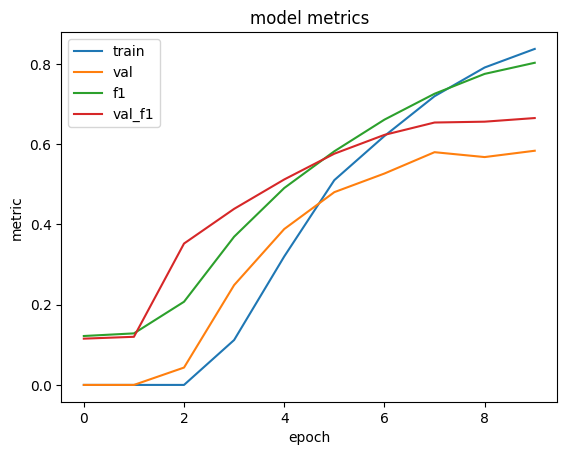

In [26]:
print(model2.history.history.keys())
plt.plot(model2.history.history['rec@prec'])
plt.plot(model2.history.history['val_rec@prec'])
plt.plot(model2.history.history['f1_score'])
plt.plot(model2.history.history['val_f1_score'])
plt.title('model metrics')
plt.ylabel('metric')
plt.xlabel('epoch')
plt.legend(['train', 'val',
            'f1', 'val_f1'], loc='upper left')
plt.show()

In [27]:
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 200, 30)           722730    
                                                                 
 conv1d_1 (Conv1D)           (None, 196, 32)           4832      
                                                                 
 conv1d_2 (Conv1D)           (None, 64, 32)            5152      
                                                                 
 average_pooling1d (Average  (None, 6, 32)             0         
 Pooling1D)                                                      
                                                                 
 flatten_1 (Flatten)         (None, 192)               0         
                                                           

### Модель №3 - 15 слоёв

In [28]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs, )

convs = []

for ks in [3,4,5,7,10]:
  dropout1 = keras.layers.Dropout(0.2)(embeddings) #1
  conv1 = keras.layers.Conv1D(kernel_size=2, filters=32, padding='same', strides=1)(dropout1) #2
  pool1 = keras.layers.AveragePooling1D(pool_size=3, padding="same")(conv1) #3
  conv2 = keras.layers.Conv1D(kernel_size=3, filters=32, padding='same', strides=1)(pool1) #4
  pool2 = keras.layers.AveragePooling1D(pool_size=5, padding="same")(conv2) #5
  conv3 = keras.layers.Conv1D(kernel_size=4, filters=32, padding='same', strides=1, kernel_regularizer='l2', activation='relu')(pool2) #6
  pool3 = keras.layers.AveragePooling1D(pool_size=7, padding="same")(conv3) #7
  dropout2 = keras.layers.Dropout(0.6)(pool3) #8
  dense1 = keras.layers.Dense(40,  activation='relu', kernel_regularizer='l2')(dropout2) #9

  convs.append(dense1)

concat = keras.layers.concatenate(convs, axis=2)
conv4 = keras.layers.Conv1D(kernel_size=3, filters=32, strides=1, padding="same")(concat) #10
pool4 = keras.layers.AveragePooling1D(pool_size=4, padding="same")(conv4) #11

dropout3 = keras.layers.Dropout(0.1)(pool4) #12
mean = keras.layers.Flatten()(dropout3) #13

dense2 = keras.layers.Dense(60, activation='relu', kernel_regularizer='l2')(mean) #14
dropout4 = keras.layers.Dropout(0.3)(dense2) #15


outputs = keras.layers.Dense(len(label2id), activation='softmax')(dropout4)


model3 = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.005)
model3.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec'), keras.metrics.F1Score(average="weighted")])

In [29]:
model3.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=2000, epochs=15, callbacks=[checkpoint, early_stop])

Epoch 1/15
22/22 [==============================] - ETA: 0s - loss: 4.4560 - rec@prec: 0.0000e+00 - f1_score: 0.1298 
Epoch 1: f1_score did not improve from 0.80319
22/22 [==============================] - 394s 18s/step - loss: 4.4560 - rec@prec: 0.0000e+00 - f1_score: 0.1298 - val_loss: 2.8974 - val_rec@prec: 0.0000e+00 - val_f1_score: 0.0955
Epoch 2/15
22/22 [==============================] - ETA: 0s - loss: 2.3820 - rec@prec: 0.0169 - f1_score: 0.2252 
Epoch 2: f1_score did not improve from 0.80319
22/22 [==============================] - 390s 18s/step - loss: 2.3820 - rec@prec: 0.0169 - f1_score: 0.2252 - val_loss: 1.8784 - val_rec@prec: 0.0987 - val_f1_score: 0.3093
Epoch 3/15
22/22 [==============================] - ETA: 0s - loss: 1.6398 - rec@prec: 0.2218 - f1_score: 0.4119 
Epoch 3: f1_score did not improve from 0.80319
22/22 [==============================] - 384s 17s/step - loss: 1.6398 - rec@prec: 0.2218 - f1_score: 0.4119 - val_loss: 1.4928 - val_rec@prec: 0.3724 - val_f1_

dict_keys(['loss', 'rec@prec', 'f1_score', 'val_loss', 'val_rec@prec', 'val_f1_score'])


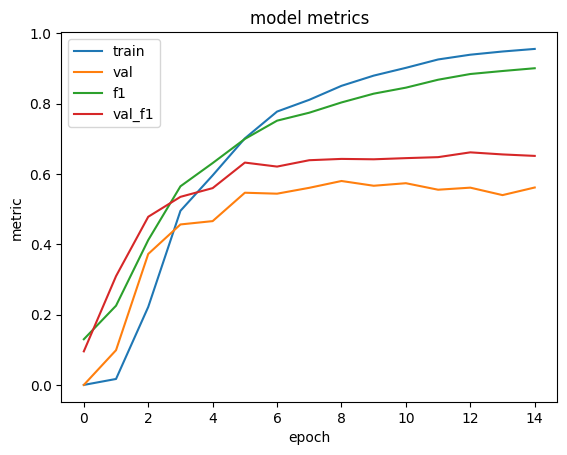

In [30]:
print(model3.history.history.keys())
plt.plot(model3.history.history['rec@prec'])
plt.plot(model3.history.history['val_rec@prec'])
plt.plot(model3.history.history['f1_score'])
plt.plot(model3.history.history['val_f1_score'])
plt.title('model metrics')
plt.ylabel('metric')
plt.xlabel('epoch')
plt.legend(['train', 'val',
            'f1', 'val_f1'], loc='upper left')
plt.show()

In [31]:
model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 200)]                0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 200, 300)             7227300   ['input_3[0][0]']             
                                                                                                  
 dropout_1 (Dropout)         (None, 200, 300)             0         ['embedding_2[0][0]']         
                                                                                                  
 dropout_3 (Dropout)         (None, 200, 300)             0         ['embedding_2[0][0]']         
                                                                                            